Import the libraries.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

The Gridworld class in the code represents a 5x5 grid environment for reinforcement learning, featuring predefined states and actions, including special states A and B with unique transitions and rewards. It includes methods to calculate state transitions and generate episodes by simulating agent movements within the grid. The simulation continues until the agent hits a grid boundary, marking the end of an episode.

In [7]:
class Gridworld:
    def __init__(self):
        # Initialize the grid world properties: a 5x5 grid
        self.grid_size = 5
        # Create a list of all possible states (coordinates) in the grid
        self.states = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size)]
        # Special states A and B with unique transitions and rewards
        self.A = (0, 1)
        self.B = (0, 3)
        self.A_prime = (4, 1)  # Transition state for A
        self.B_prime = (2, 3)  # Transition state for B
        # Define possible actions
        self.actions = ['north', 'south', 'east', 'west']
        # Calculate transitions for each state and action
        self.transitions = {state: self.calculate_transitions(state) for state in self.states}

    def calculate_transitions(self, state):
        # Determine possible next states and rewards for each action
        transitions = {}
        for action in self.actions:
            transitions[action] = self.get_next_state(state, action)
        return transitions

    def get_next_state(self, state, action):
        # Compute the next state given the current state and action
        i, j = state
        # Special handling for states A and B
        if state == self.A:
            return self.A_prime, 10
        elif state == self.B:
            return self.B_prime, 5

        # Movement logic for the grid
        if action == 'north' and i > 0:
            return (i - 1, j), 0
        elif action == 'south' and i < self.grid_size - 1:
            return (i + 1, j), 0
        elif action == 'east' and j < self.grid_size - 1:
            return (i, j + 1), 0
        elif action == 'west' and j > 0:
            return (i, j - 1), 0
        else:
            # Stay in the same state with a penalty if moving outside the grid
            return state, -1

    def generate_episode(self):
        # Generate a random episode (sequence of state, action, reward)
        episode = []
        # Start from a random state
        state = (np.random.randint(self.grid_size), np.random.randint(self.grid_size))
        while True:
            # Select a random action
            action = np.random.choice(self.actions)
            next_state, reward = self.transitions[state][action]
            episode.append((state, action, reward))
            # Episode ends if the agent hits the grid boundary
            if next_state == state and reward == -1:
                break
            state = next_state
        return episode

The MonteCarloSimulation class is designed to perform a Monte Carlo simulation on a given grid environment (env). It initializes with a specified environment and a discount factor for future rewards, and maintains a matrix to store state value estimates. The run_simulation method executes the simulation over a defined number of episodes, updating state value estimates based on the returns (sum of discounted rewards) from each state, considering only the first visit to each state within an episode.

In [8]:
class MonteCarloSimulation:
    def __init__(self, env, discount_factor=0.9):
        # Initialize the Monte Carlo simulation with an environment and a discount factor
        self.env = env
        self.discount_factor = discount_factor
        # Initialize a matrix for storing value estimates
        self.value_estimates = np.zeros((env.grid_size, env.grid_size))

    def run_simulation(self, num_episodes):
        # Run the simulation over a specified number of episodes
        # Dictionary to keep track of returns for each state
        returns = {(i, j): [] for i in range(self.env.grid_size) for j in range(self.env.grid_size)}
        for _ in range(num_episodes):
            # Generate an episode
            episode = self.env.generate_episode()
            G = 0  # Initialize the return
            visited_states = set()  # Track visited states in the episode
            for (state, _, reward) in reversed(episode):
                # Only consider the first visit to each state in an episode
                if state not in visited_states:
                    visited_states.add(state)
                    # Calculate the return (sum of discounted rewards)
                    G = reward + self.discount_factor * G
                    # Record the return for this state
                    returns[state].append(G)
                    # Update the value estimate for the state
                    self.value_estimates[state] = np.mean(returns[state])

Heatmap Plot: Visualizes the state values in a 2D grid format, corresponding to the layout of the Gridworld environment.

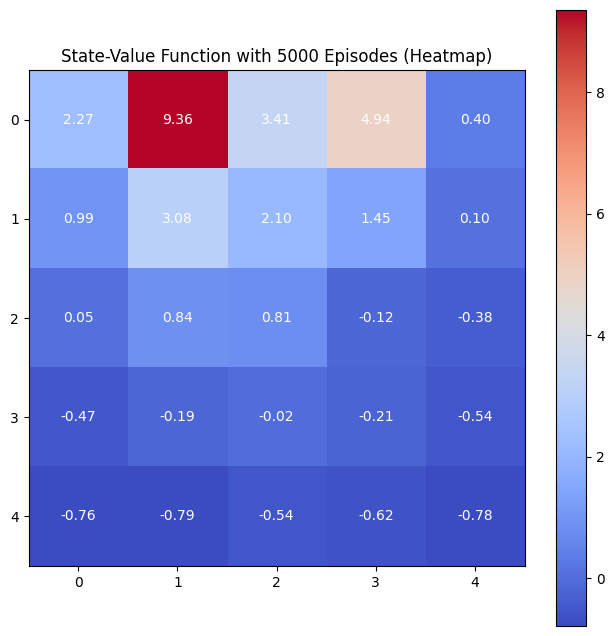

In [9]:
# Initialize the gridworld environment
env = Gridworld()
# Create a Monte Carlo simulation instance
mc_sim = MonteCarloSimulation(env)

# Run the simulation for 5000 episodes
mc_sim.run_simulation(5000)

# Reshape the value estimates for visualization
value_grid = mc_sim.value_estimates.reshape(env.grid_size, env.grid_size)

# Plotting the heatmap of state values
plt.figure(figsize=(8, 8))
cmap = plt.cm.coolwarm
plt.imshow(value_grid, cmap=cmap, interpolation="nearest")
for i in range(env.grid_size):
    for j in range(env.grid_size):
        plt.text(j, i, f"{value_grid[i, j]:.2f}", ha="center", va="center", color="w")
plt.colorbar()
plt.title('State-Value Function with 5000 Episodes (Heatmap)')
plt.show()


Bar Chart Plot: Presents the state values as a series of bars, making it easy to compare individual states directly.

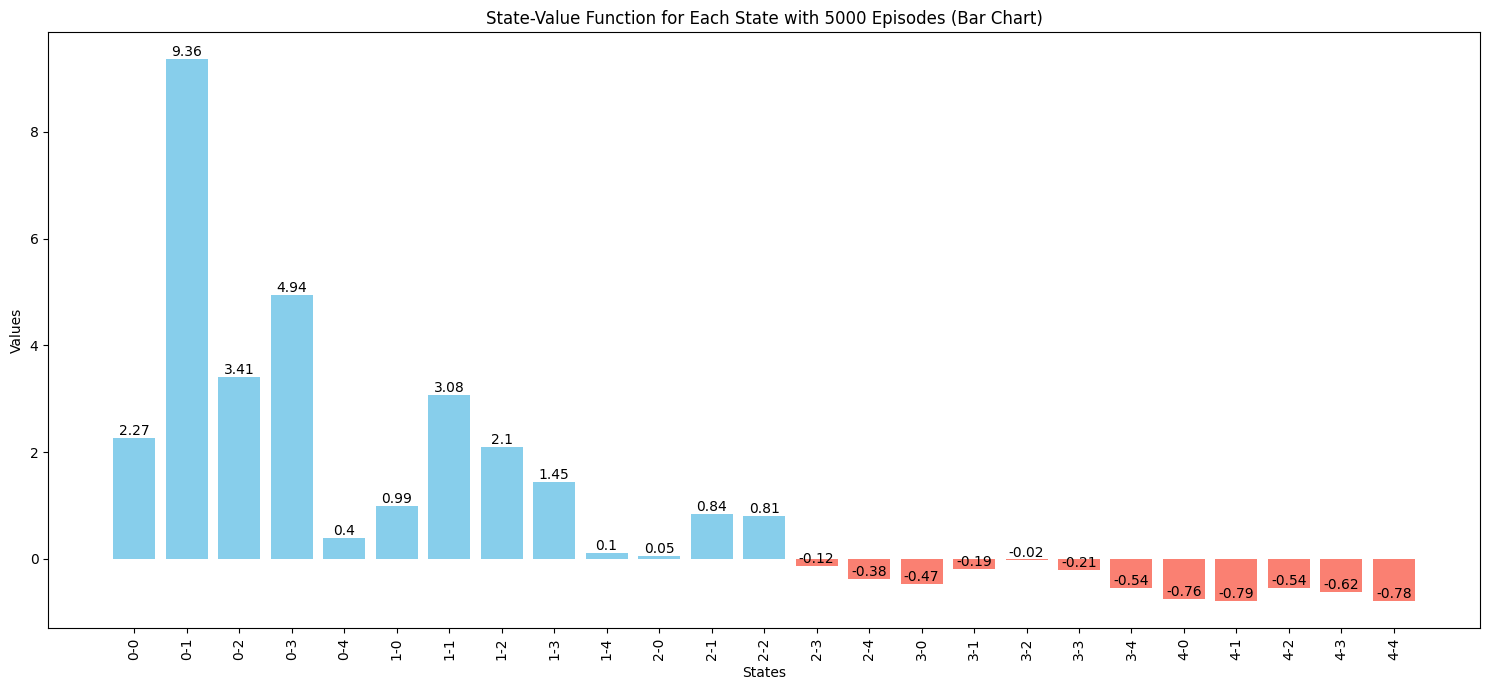

In [10]:
# Flattening the value grid for a bar chart plot
flat_values = value_grid.flatten()
# Generating state labels for the bar chart
state_labels = [f"{i}-{j}" for i in range(env.grid_size) for j in range(env.grid_size)]

# Plotting the bar chart of state values
plt.figure(figsize=(15, 7))
colors = ['skyblue' if val >= 0 else 'salmon' for val in flat_values]
bars = plt.bar(state_labels, flat_values, color=colors)
# Annotating values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('States')
plt.ylabel('Values')
plt.title('State-Value Function for Each State with 5000 Episodes (Bar Chart)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()